In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.utils as util
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.ensemble import GradientBoostingClassifier

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Load spam dataset

In [2]:
train_df = pd.read_csv('datasets/spam-train.txt', delim_whitespace=True, header=None)
test_df = pd.read_csv('datasets/spam-test.txt', delim_whitespace=True, header=None)

# Create matrices from dataframes
Y_train = train_df[0].as_matrix()
Y_test = test_df[0].as_matrix()

X_train = train_df.drop(0, axis=1).as_matrix()
X_test = test_df.drop(0, axis=1).as_matrix()

print 'Spam train:\t%d rows x %d features' % (X_train.shape[0], X_train.shape[1])
print 'Spam test:\t%d rows x %d features' % (X_test.shape[0], X_test.shape[1])

Spam train:	7093 rows x 102 features
Spam test:	10056 rows x 102 features


# Uncertainty sampling

In [3]:
class ActiveLearner:
    
    def __init__(self, model, X):
        self.model = model
        self.X = X
        self.unknownSamples = np.arange(0, X_train.shape[0])
        self.knownSamples = np.array([], dtype=int)
        self.knownLabels = np.array([], dtype=int)
 
    def requestUncertain(self, step):
        Y_pred = self.model.predict_proba(self.X[self.unknownSamples, :])[:, 0]
        trueClass = Y_pred
        falseClass = 1 - trueClass
        margin = np.absolute(trueClass - falseClass)
        uncertain = np.argsort(margin)
        return self.unknownSamples[uncertain[:step]]
    
    def fit(self, newSamples, newLabels):
        self.knownSamples = np.append(self.knownSamples, newSamples)
        self.knownLabels = np.append(self.knownLabels, newLabels)
        self.unknownSamples = np.setdiff1d(self.unknownSamples, self.knownSamples)
        self.model.fit(self.X[self.knownSamples, :], self.knownLabels)
        return self.model

# Parameters and common variables

In [4]:
n_initSamples = 10
step = 100

sss = StratifiedShuffleSplit(Y_train, n_iter=1, train_size=n_initSamples)
for train_index, test_index in sss:
    initSamples = train_index
    break

# Run active learning with margin sampling

In [5]:
train_loss = np.array([])
test_loss = np.array([])
n_samples = np.array([])

freeSamples = np.arange(0, X_train.shape[0])
learner = ActiveLearner(GradientBoostingClassifier(), X_train)

while len(freeSamples) > 0:
    
    if len(freeSamples) == len(Y_train):    
        samples = initSamples   
    else:    
        samples = learner.requestUncertain(step)
            
    freeSamples = np.setdiff1d(freeSamples, samples)
    model = learner.fit(samples, Y_train[samples])
    
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    
    train_loss = np.append(train_loss, mean_squared_error(Y_train_pred, Y_train))
    test_loss = np.append(test_loss, mean_squared_error(Y_test_pred, Y_test))
    n_samples = np.append(n_samples, X_train.shape[0] - len(freeSamples))
    
    print 'Iter %d\tTrain loss: %0.5f\tTest loss: %0.5f\tNumber of samples: %d' \
        % (len(train_loss), train_loss[-1], test_loss[-1], n_samples[-1])

Iter 1	Train loss: 0.34936	Test loss: 0.35650	Number of samples: 10
Iter 2	Train loss: 0.22642	Test loss: 0.19879	Number of samples: 110
Iter 3	Train loss: 0.12068	Test loss: 0.12589	Number of samples: 210
Iter 4	Train loss: 0.06739	Test loss: 0.21669	Number of samples: 310
Iter 5	Train loss: 0.04441	Test loss: 0.10581	Number of samples: 410
Iter 6	Train loss: 0.03525	Test loss: 0.07627	Number of samples: 510
Iter 7	Train loss: 0.02665	Test loss: 0.06384	Number of samples: 610
Iter 8	Train loss: 0.02326	Test loss: 0.05519	Number of samples: 710
Iter 9	Train loss: 0.01537	Test loss: 0.05330	Number of samples: 810
Iter 10	Train loss: 0.01353	Test loss: 0.04684	Number of samples: 910
Iter 11	Train loss: 0.01057	Test loss: 0.04843	Number of samples: 1010
Iter 12	Train loss: 0.00930	Test loss: 0.05091	Number of samples: 1110
Iter 13	Train loss: 0.00945	Test loss: 0.04753	Number of samples: 1210
Iter 14	Train loss: 0.00818	Test loss: 0.04276	Number of samples: 1310
Iter 15	Train loss: 0.0080

# Run active learning with random sampling

In [6]:
train_loss_random = np.array([])
test_loss_random = np.array([])
n_samples_random = np.array([])

freeSamples = np.arange(0, X_train.shape[0])
learner = ActiveLearner(GradientBoostingClassifier(), X_train)

while len(freeSamples) > 0:
    
    if len(freeSamples) == len(Y_train):    
        samples = initSamples  
    else:    
        samples = np.random.choice(freeSamples, size=min(step, len(freeSamples)), replace=False)
            
    freeSamples = np.setdiff1d(freeSamples, samples)
    model = learner.fit(samples, Y_train[samples])
    
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    
    train_loss_random = np.append(train_loss_random, mean_squared_error(Y_train_pred, Y_train))
    test_loss_random = np.append(test_loss_random, mean_squared_error(Y_test_pred, Y_test))
    n_samples_random = np.append(n_samples_random, X_train.shape[0] - len(freeSamples))
    
    print 'Iter %d\tTrain loss: %0.5f\tTest loss: %0.5f\tNumber of samples: %d' \
        % (len(train_loss_random), train_loss_random[-1], test_loss_random[-1], n_samples_random[-1])

Iter 1	Train loss: 0.34936	Test loss: 0.35650	Number of samples: 10
Iter 2	Train loss: 0.10799	Test loss: 0.14777	Number of samples: 110
Iter 3	Train loss: 0.08628	Test loss: 0.17204	Number of samples: 210
Iter 4	Train loss: 0.06020	Test loss: 0.08930	Number of samples: 310
Iter 5	Train loss: 0.05245	Test loss: 0.07428	Number of samples: 410
Iter 6	Train loss: 0.04850	Test loss: 0.06712	Number of samples: 510
Iter 7	Train loss: 0.04906	Test loss: 0.07488	Number of samples: 610
Iter 8	Train loss: 0.04483	Test loss: 0.07369	Number of samples: 710
Iter 9	Train loss: 0.04497	Test loss: 0.07339	Number of samples: 810
Iter 10	Train loss: 0.04230	Test loss: 0.06404	Number of samples: 910
Iter 11	Train loss: 0.03863	Test loss: 0.05758	Number of samples: 1010
Iter 12	Train loss: 0.04004	Test loss: 0.06494	Number of samples: 1110
Iter 13	Train loss: 0.03468	Test loss: 0.06434	Number of samples: 1210
Iter 14	Train loss: 0.03807	Test loss: 0.05827	Number of samples: 1310
Iter 15	Train loss: 0.0365

# Draw plots

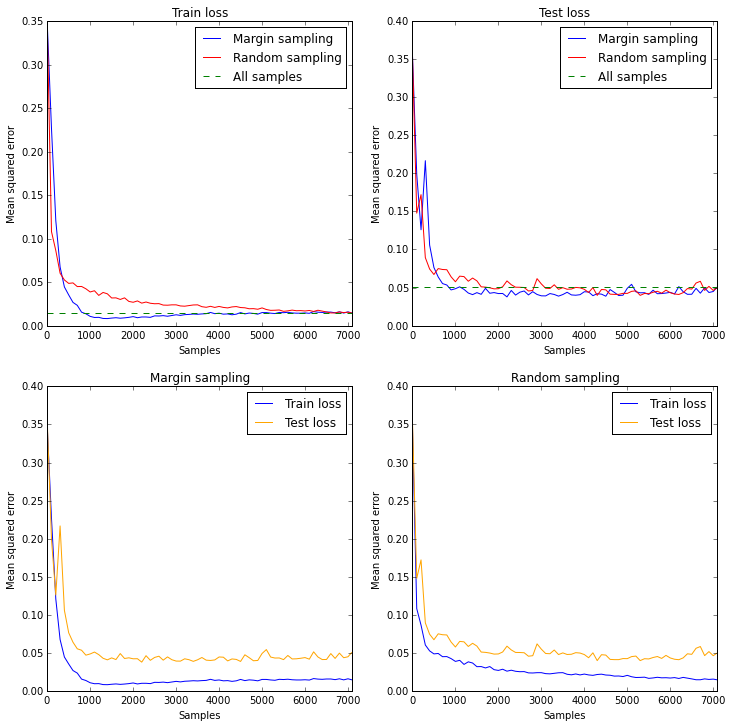

In [8]:
pl.figure(figsize=(12, 12))

pl.subplot(2, 2, 1)
margin_train, = pl.plot(n_samples, train_loss, color='blue')
random_train, = pl.plot(n_samples_random, train_loss_random, color='red')
all_train = pl.axhline(y=train_loss[-1], color='green', linestyle='--')
pl.title('Train loss')
pl.legend([margin_train, random_train, all_train], ['Margin sampling', 'Random sampling', 'All samples'])
pl.xlabel('Samples')
pl.ylabel('Mean squared error')
pl.xlim(n_samples[0], n_samples[-1])
    
pl.subplot(2, 2, 2)
margin_test, = pl.plot(n_samples, test_loss, color='blue')
random_test, = pl.plot(n_samples_random, test_loss_random, color='red')
all_test = pl.axhline(y=test_loss[-1], color='green', linestyle='--')
pl.title('Test loss')
pl.legend([margin_test, random_test, all_test], ['Margin sampling', 'Random sampling', 'All samples'])
pl.xlabel('Samples')
pl.ylabel('Mean squared error')
pl.xlim(n_samples[0], n_samples[-1])

pl.subplot(2, 2, 3)
margin_train_2, = pl.plot(n_samples, train_loss, color='blue')
margin_test_2, = pl.plot(n_samples, test_loss, color='orange')
pl.title('Margin sampling')
pl.legend([margin_train_2, margin_test_2], ['Train loss', 'Test loss'])
pl.xlabel('Samples')
pl.ylabel('Mean squared error')
pl.xlim(n_samples[0], n_samples[-1])
    
pl.subplot(2, 2, 4)
random_train_2, = pl.plot(n_samples, train_loss_random, color='blue')
random_test_2, = pl.plot(n_samples, test_loss_random, color='orange')
pl.title('Random sampling')
pl.legend([random_train_2, random_test_2], ['Train loss', 'Test loss'])
pl.xlabel('Samples')
pl.ylabel('Mean squared error')
pl.xlim(n_samples[0], n_samples[-1])

pl.show()